# Build Synapses

**Contents**

- [brainpy.SynType](#brainpy.SynType)
- [brainpy.SynConn](#brainpy.SynConn)
- [brainpy.connect](#brainpy.connect)
- [Other Operations](#Other-Operations)

Same with the neuron models, the *definition* and *usage* of the synapse model are separated from each other. Specifically, two classes should be used:

- ``brainpy.SynType``: Define the abstract synapse model.
- ``brainpy.SynConn``: Use the abstract synapse model to generate a concrete synapse connection.

The synapse model should consider two things:

- The ``connection`` between neuron groups: how the pre-synaptic neurons connect to the post-synaptic neurons.
- What ``computation`` is used on each synaptic connection. 

In the next, I will illustrate how to define a synaptic model by using ``brainpy.SynType``, and then tell you how to use your defined model with ``brainpy.SynConn``. 

Before we start, let's import your favorite BrainPy and NumPy packages.

In [1]:
import sys
sys.path.append('../../')

import brainpy as bp
import numpy as np

## brainpy.SynType

### Support for `SynType` definition

Same with the neuron models, BrainPy provides several interfaces to support the SynType definition. Users can combine them arbitrarily to define a synapse model. Specifically, the supports include:

- **Numerical integration of [differential equations](https://brainpy.readthedocs.io/en/latest/advanced/differential_equations.html)**: by using the decorator `@brainpy.integrate`, users can define an integrator for a ODE or SDE. The numerical method for integration can be chosen from the supported [methods](https://brainpy.readthedocs.io/en/latest/advanced/numerical_integrators.html).

- **Synaptic state management**: BrainPy provides `brainpy.SynState` for convenient synapse state management. 

- **Automatical synaptic delay**: The synapse modeling usually includes a delay time (typically 0.3–0.5 ms) required for a neurotransmitter to be released from a presynaptic membrane, diffuse across the synaptic cleft, and bind to a receptor site on the post-synaptic membrane. BrainPy provides `@brainpy.delayed` decorator for automatical state delay. On the functions which use the delayed state, you just need to add the `@delayed` decorator on them. 

### Scalar-based Synapse Model

The updating logic of a synapse should consider the connections between groups and the computations on each connection. Fortunately, BrainPy provides a scalar-based definition paradigm, in which you only need to consider the computation on each connection. Let's first take the AMPA synapse model as an illustrating example.

The formal equations of an AMPA synapse is given by:

$$
\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k}) \quad (1) \\
I_{syn}= \bar{g}_{syn} s (V-E_{syn}) \quad (2)
$$


where $\bar{g}_{syn}$ is the maximum synaptic conductance, $s$ is the gating variable, and $V$ is the membrane potential of the postsynaptic neuron. The time constant $\tau_{decay}$ is about 2ms and the equilibrium potential $E_{syn}$ for AMPA synapse is set to 0 mV.

In [2]:
# model parameters 

tau_decay = 2.   # time constant of the dacay after synapse respond to a neurontransmitter.
g_max = .10      # Voltage-controlled conductance per unit area
                 # associated with the Sodium (Na) and Potassium (K) 
                 # ion-channels on the synapse (postsynaptic membrane).
E = 0.           # The equilibrium potentials for the synapse.

In [3]:
# use "@integrate" to define the gating variable dynamics

@bp.integrate
def int_s(s, t):
    return - s / tau_decay

In [4]:
# use "SynState" to define the synapse state

ST = bp.SynState('s', help='AMPA synapse state.')

Based on the above definition, the update logic of the synapse model (equation (1)) from the current time point ($t$) to the next time point $(t + dt)$ can be defined as:

In [5]:
def update_by_scalar(ST, _t, pre):
    s = int_s(ST['s'], _t)
    if pre['spike'] == True:
        s += 1
    ST['s'] = s

The output synaptic value onto the post-synaptic neurons (equation (2)) can be defined as:

In [6]:
@bp.delayed
def output_by_scalar(ST, post):
    I_syn = - g_max * ST['s'] * (post['V'] - E)
    post['input'] += I_syn

As you can see, the code writting is very similar to the original equations. 

Another thing we should pay attention to is that the `update()` function needs pre-synaptic neuron state `pre`, and the `output()` function requires post-synaptic neuron state `post`. If you want someone else to use this model, you can make clear statements about the data need to satisfy (optional). Like this,

In [7]:
requires = dict(
    pre=bp.types.NeuState('spike', help='Presynaptic neuron state must have "spike" item.'),
    post=bp.types.NeuState('V', 'input', help='Postsynaptic neuron state must have "V" and "input" item.')
)

Putting together, an AMPA synapse model is defined as:

In [8]:
AMPA1 = bp.SynType(name='AMPA_scalar',  ST=ST, requires=requires, 
                   steps=(update_by_scalar, output_by_scalar), mode='scalar')

### Matrix-based Synapse Model

Contrary to the scalar-based synapse model, the matrix-based model means each item in the synapse state ``ST`` is a matrix with the shape of `(num_pre, num_post)`. And the updating logic in the matrix-based model will explicitly utilize the synaptic connections (i.e., connectivity matrix with the shape of `(num_pre, num_post)`). 

For example, if you have the followng connection matrix (`conn_mat`), 


<img src="../images/syn-example-conn_mat.png" width="400 px" align="left">

the updating logic of the AMPA synapse can be coded as:

In [9]:
def update_by_mat(ST, _t, pre, conn_mat):
    s = int_s(ST['s'], _t)
    # when pre-synaptic neuron generate spikes, the  
    # corresponding position in `s` will add 1.
    s += pre['spike'].reshape((-1, 1)) * conn_mat
    ST['s'] = s

Similarly, the output function of the AMPA synapse will be adapted to

In [10]:
@bp.delayed
def output_by_mat(ST, post):
    g = g_max * np.sum(ST['s'], axis=0)
    post['input'] -= g * (post['V'] - E)

Here, in order to compute the AMPA updating logic, a new data `conn_mat` will be used. We can make a data declaration as (optional)

In [11]:
requires = dict(
    pre=bp.types.NeuState('spike'),
    post=bp.types.NeuState('V', 'input'),
    conn_mat=bp.types.MatConn(help='Connection matrix between pre- and post- synaptic neuron group.')
)

Putting together, a matrix-based AMPA synapse model is defined as

In [12]:
AMPA2 = bp.SynType(name='AMPA_matrix',  ST=ST, requires=requires, 
                   steps=(update_by_mat, output_by_mat), mode='matrix')

**Event-based upating**

The computation logic defined in `update_by_mat()` is very inefficient. This is because it is uncommon for a neuron to generate a spike, and in a group of neuron, the generated spikes (`pre['spike']`) are usually sparse. Therefore, for many time points, there are many zeros in `pre['spike']`, which results `s` add many unnecessary zeros (`s += pre['spike'].reshape((-1, 1)) * conn_mat`). Alternatively, we can update `s` when the pre-synaptic neuron produces a spike event:

In [13]:
def update_by_mat(ST, _t, pre, conn_mat):
    s = int_s(ST['s'], _t)
    
    # event-based updating
    for i in range(pre['spike'].shape[0]):
        if pre['spike'][i] > 0:
            s[i] += conn_mat[i]
    
    ST['s'] = s

In such a way, only when pre neuron $i$ produces a spike, the correponding `s[i]` will carry out the adding operation (`s[i] += conn_mat[i]`). In practice, this kind of updating method is much more efficient than the previous one.

### Vector-based Synapse Model

Matrix-based model may be straightforward, but can cause severe wasted RAM memory and inefficient computation. Imaging you want to connect 10,000 pre-synaptic neurons to 10,000 post-synaptic neurons with a 10% random probability. Using *matrix*, you need $10^8$ floats to save the synaptic state, and at each update step, you need do computation on $10^8$ floats (for example, the computation in the above `int_s()`). Actually, the number of values you truely needed is $10^7$. See, there is a huge memory waste and computing resource inefficiency. 

An effective method to solve this problem is to use *vector* to store the connectivity between neuron groups and the corresponding synaptic states. For the above defined connectivity `conn_mat`, we can align the connected pre-synaptic neurons and the post-synaptic neurons by two one-dimensional arrays: *pre_ids* and *post_ids*,

<img src="../images/syn-example-pre_ids-post_ids.png" width="700 px" align="left">

In such a way, we only need two vectors (each has $10^7$ floats). And, at each time step, we just compute `int_s()` on a synaptic state vector with $10^7$ floats. 

However, the synaptic computation based on vectors also has problems. That is, how to retrieve the synapse states which connected with the pre-synaptic neuron $i$ and the post-synaptic neuron $j$. 

A simple way is to create a `pre2syn` list, where each `pre2syn[i]` stores the synaptic state indexes projected from the pre-synaptic neuron $i$.  

<img src="../images/syn-example-pre2syn.png" width="200 px" align="left">

Similarly, we can create a `post2syn` list to indicate the connections between synapses and postsynaptic neurons. For each post-synaptic neuron $j$, `post2syn[j]` stores the indexes of synaptic elements which connected to post neuron $j$. 

<img src="../images/syn-example-post2syn.png" width="200 px" align="left">

Also, the direct mapping between the pre-synaptic neurons and the post-synaptic neurons can be established. `pre2post` saves the connected post-synaptic neurons indexes, in which `pre2post[i]` retrieves the post neuron ids projected from pre-synaptic neuron $i$. `post2pre` saves the pre-synaptic neurons indexes, in which `post2pre[j]` retrieves the pre-syanptic neuron ids which project to post-synaptic neuron $j$. 

<img src="../images/syn-example-pre2post.png" width="200 px" align="left">

<img src="../images/syn-example-post2pre.png" width="200 px" align="left">

Based on these connectivity mappings, we can define another version of AMPA synapse model by using `pre2syn` and `post2syn`:

In [14]:
def update_by_vector(ST, _t, pre, pre2syn):
    s = ints(ST['s'], _t)
    
    for i in range(pre['spike'].shape[0]):
        if pre['spike'][i] > 0:
            # if pre[i] produce a spike, then the  
            # connected synapses should add 1.
            syn_ids = pre2syn[i]
            s[syn_ids] += 1.

    ST['s'] = s

@bp.delayed
def output_by_vector(ST, post, post2syn):
    g = np.zeros(len(post2syn), dtype=np.float_)
    for post_id, syn_ids in enumerate(post2syn):
        g[post_id] = np.sum(g_max * ST['s'][syn_ids])
    
    post['input'] -= post_cond * (post['V'] - E)
    
requires = dict(
    pre=bp.types.NeuState('spike'),
    post=bp.types.NeuState('V', 'input'),
    pre2syn = bp.types.ListConn(),
    post2syn = bp.types.ListConn()
)

AMPA3 = bp.SynType(name='AMPA_vector', ST=ST,  requires=requires,
                   steps=(update_by_vector, output_by_vector),  mode='vector')

Here, we get a vector-based synapse model. 

However, it is not perfect. This is because the computation of `s` and `g` relies on many indexing (`s[syn_ids]` and `ST['s'][syn_ids]`). When the number of the connected pre/post-synaptic neurons is big, the computation based on the indexing will be inefficient. On the contrary, the slicing is much effective than the indexing. Let's illustrate this by the following experiment.

In [15]:
# we create an array, and want to retrieve the half of them

num = 10000
array = np.ones(num)

In [16]:
# method 1: using indexing

idx = np.arange(0, num//2)
%timeit array[idx]

13.9 µs ± 584 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
# method 2: using slicing

%timeit array[0: num]

194 ns ± 2.38 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


As you can see, the above experiment demonstrates that the slicing is 72x faster than the indexing (13.9 µs / 194 ns).

So, here, we should avoid to use the indexing of `post2syn`. Instead, we can create a `post_slice_syn` connection structure which stores the *start* and the *end* position on the synpase state for each connected post-synaptic neuron $j$. `post_slice_syn` can be implemented by aligning the pre ids according to the sequential post id $0, 1, 2, ...$ (look the following illustrating figure). For each post neuron $j$, `start, end = post_slice_syn[j]` retrieves the start/end position of the connected synapse states.

<img src="../images/syn-example-post_slice_syn.png" width="700 px" align="left">

Therefore, the updating logic of AMPA synapse can again be coded as:

In [18]:
@bp.delayed
def output_by_vector2(ST, post, post_slice_syn):
    g = np.zeros(len(post_slice_syn), dtype=np.float_)
    for post_id, position in enumerate(post_slice_syn):
        start = position[0]
        end = position[1]
        g[post_id] = np.sum(g_max * ST['s'][start: end])
    
    post['input'] -= post_cond * (post['V'] - E)
    
requires = dict(
    pre=bp.types.NeuState('spike', ),
    post=bp.types.NeuState('V', 'input'),
    pre2syn = bp.types.ListConn(),
    post_slice_syn = bp.types.Array(dim=2)
)

AMPA4 = bp.SynType(name='AMPA_vector', ST=ST,  requires=requires,
                   steps=(update_by_vector, output_by_vector2), 
                   mode='vector')

Similarly, a connection `pre_slice_syn` can also be implemented. 

<img src="../images/syn-example-pre_slice_syn.png" width="700 px" align="left">

## brainpy.SynConn

The above `brainpy.SynType` only defines the abstract synaptic model. To implement concreate synaptic computation, we should use `brainpy.SynConn`. A ``brainpy.SynConn`` receives the following parameters:

- ``model``: The synapse type will be used to generate a synapse connection. It must be an instance of `brainpy.SynType`.
- ``pre_group``: The presynaptic neuron group. An instance of `brainpy.NeuGroup`.
- ``post_group``: The postsynaptic neuron group. An instance of `brainpy.NeuGroup`.
- ``conn``: The connection method to create synaptic connectivity between the neuron groups.
- ``monitors``: The items to monitor (record the history values.)
- ``delay``: The time of the synapse delay (in milliseconds).
- ``satisfies``: The data to satisfy the model requires.

Let's illustrate the usage of `SynConn` by connecting two LIF neurons. The LIF neuron model can be get from our [BrainPy-Models](https://brainpy-models.readthedocs.io/) (a package named "bpmodels"), which implements commonly used neuron and synapse models. 

In [19]:
from bpmodels.neurons import get_LIF

LIF = get_LIF(V_rest=-65., V_reset=-65., V_th=-55.)

pre = bp.NeuGroup(LIF, 1, monitors=['spike', 'V'])
pre.ST['V'] = -65.

post = bp.NeuGroup(LIF, 1, monitors=['V'])
post.ST['V'] = -65.

In [20]:
syn_conn = bp.SynConn(model=AMPA1,  # use above "AMPA1" to do the synaptic computation
                      pre_group=pre, 
                      post_group=post,
                      conn=bp.connect.All2All(),  # connect pre- and post- group by All2All method
                      monitors=['s'], 
                      delay=1.5)

# You can set the updating order for each step function
# The functions can be scheduled can get from "syn_conn.get_schedule()"
syn_conn.set_schedule(['input', 'update_by_scalar', 'output_by_scalar', 'monitor'])

In [21]:
net = bp.Network(pre, syn_conn, post)
net.run(duration=100., inputs=(pre, "ST.input", 20.))

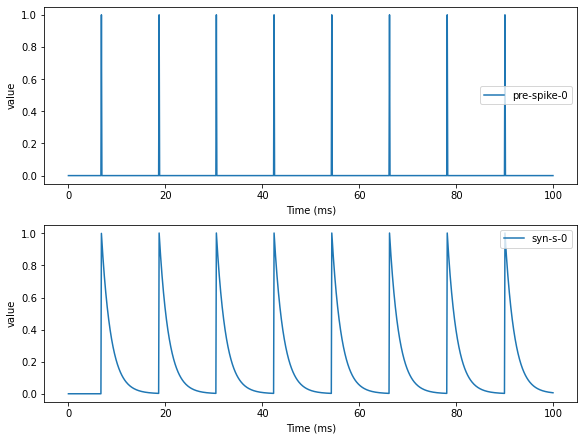

In [26]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(pre.mon.ts, pre.mon.spike, legend='pre-spike')

fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(syn_conn.mon.ts, syn_conn.mon.s, legend='syn-s', show=True)

## brainpy.connect

The above example in [brainpy.SynConn](#brainpy.SynConn) shows a "strange" thing in which the data `requires` in abstract `SynType` model (such as *pre, post, post2syn, pre2syn*, ...) do not `satisfies` in concrete `SynConn` instance. Actually, this is because BrainPy automatically do these thing for you.

- If you provide `pre_group` in brainpy.SynConn, the data `pre` will be automtically initialized. 
- If you provide `post_group` in brainpy.SynConn, the data `post` will be automtically initialized. 
- If you provide `conn` by using methods of `brainpy.connect.xxx`, the connection data like (`pre_ids`, `post_ids`, `conn_mat`, `pre2post`, `post2pre`, `pre2syn`, `post2syn`, `pre_slice_syn`, and `post_slice_syn`) will be initialized as needed. 

Otherwise, if users instantiate `brainpy.SynConn` without *pre_group*, *post_group*, *conn*, the data like *pre, post, post2syn, pre2syn* should provide by hand. Like, 

In [27]:
syn_conn = bp.SynConn(AMPA4, pre_group=pre, post_group=post)
syn_conn.pre2syn = ...
syn_conn.post_slice_syn = ...

Actually, BrainPy provides several commonly used connection methods in ``brainpy.connect`` module (see the follows). They are all inherited from the base class `brainpy.connect.Connector`. Users can also customize their synaptic connectivity by class inheritance. 

### brainpy.connect.One2One

The neurons in the pre-synaptic neuron group only connect to the neurons
in the same position of the post-synaptic group. Thus, this connection
requires the indices of two neuron groups same. Otherwise, an error will
occurs.

<img src="../images/one2one.png" width="200 px" align="left">

### brainpy.connect.All2All

All neurons of the post-synaptic population form connections with all
neurons of the pre-synaptic population (dense connectivity). Users can
choose whether connect the neurons at the same position
(`include_self=True or False`).

<img src="../images/all2all.png" width="200 px" align="left">

### brainpy.connect.GridFour

`GridFour` is the four nearest neighbors connection. Each neuron connect to its
nearest four neurons.

<img src="../images/grid_four.png" width="250 px" align="left">

### brainpy.connect.GridEight

`GridEight` is eight nearest neighbors connection. Each neuron connect to its
nearest eight neurons.

<img src="../images/grid_eight.png" width="250 px" align="left">

### brainpy.connect.GridN

`GridN` is also a nearest neighbors connection. Each neuron connect to its
nearest $2N \cdot 2N$ neurons.

<img src="../images/grid_N.png" width="250 px" align="left">

### brainpy.connect.FixedProb

For each post-synaptic neuron, there is a fixed probability that it forms a connection
with a neuron of the pre-synaptic population. It is basically a all_to_all projection,
except some synapses are not created, making the projection sparser.

<img src="../images/fixed_proab.png" width="200 px" align="left">

### brainpy.connect.FixedPreNum

Each neuron in the post-synaptic population receives connections from a
fixed number of neurons of the pre-synaptic population chosen randomly.
It may happen that two post-synaptic neurons are connected to the same
pre-synaptic neuron and that some pre-synaptic neurons are connected to
nothing.

<img src="../images/fixed_pre_num.png" width="200 px" align="left">

### brainpy.connect.FixedPostNum

Each neuron in the pre-synaptic population sends a connection to a fixed number of neurons
of the post-synaptic population chosen randomly. It may happen that two pre-synaptic neurons
are connected to the same post-synaptic neuron and that some post-synaptic neurons receive
no connection at all.

<img src="../images/fixed_post_num.png" width="200 px" align="left">

### brainpy.connect.GaussianProb


Builds a Gaussian connection pattern between the two populations, where
the connection probability decay according to the gaussian function.

Specifically,

$$
p=\exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma^2})
$$

where $(x, y)$ is the position of the pre-synaptic neuron
and $(x_c,y_c)$ is the position of the post-synaptic neuron.

For example, in a $30 \textrm{x} 30$ two-dimensional networks, when
$\beta = \frac{1}{2\sigma^2} = 0.1$, the connection pattern is shown
as the follows:

<img src="../images/gaussian_prob.png" width="500 px" align="left">

### brainpy.connect.GaussianWeight

Builds a Gaussian connection pattern between the two populations, where
the weights decay with gaussian function.

Specifically,

$$w(x, y) = w_{max} \cdot \exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma^2})$$

where $(x, y)$ is the position of the pre-synaptic neuron (normalized
to [0,1]) and $(x_c,y_c)$ is the position of the post-synaptic neuron
(normalized to [0,1]), $w_{max}$ is the maximum weight. In order to void
creating useless synapses, $w_{min}$ can be set to restrict the creation
of synapses to the cases where the value of the weight would be superior
to $w_{min}$. Default is $0.01 w_{max}$.


In [23]:
import matplotlib.pyplot as plt

def show_weight(pre_ids, post_ids, weights, geometry, neu_id):
    height, width = geometry
    ids = np.where(pre_ids == neu_id)[0]
    post_ids = post_ids[ids]
    weights = weights[ids]

    X, Y = np.arange(height), np.arange(width)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros(geometry)
    for id_, weight in zip(post_ids, weights):
        h, w = id_ // width, id_ % width
        Z[h, w] = weight

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

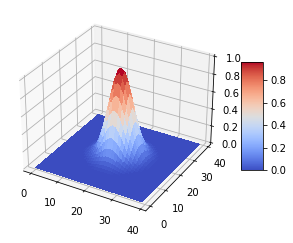

In [24]:
gaussian_weight = bp.connect.GaussianWeight(
    sigma=0.1, w_max=1., w_min=0.01,
    normalize=True, include_self=True)
pre_geom = post_geom = (40, 40)
indices = np.arange(pre_geom[0] * pre_geom[1]).reshape(pre_geom)
gaussian_weight(indices, indices)

pre_ids = gaussian_weight.pre_ids
post_ids = gaussian_weight.post_ids
weights = gaussian_weight.weights
show_weight(pre_ids, post_ids, weights, pre_geom, 820)

### brainpy.connect.DOG


Builds a Difference-Of-Gaussian (dog) connection pattern between the two populations.

Mathematically,

$$
w(x, y) = w_{max}^+ \cdot \exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma_+^2})
    - w_{max}^- \cdot \exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma_-^2})
$$

where weights smaller than $0.01 * abs(w_{max} - w_{min})$ are not created and
self-connections are avoided by default (parameter allow_self_connections).


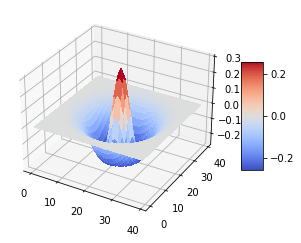

In [25]:
dog = bp.connect.DOG(
    sigmas=(0.08, 0.15),
    ws_max=(1.0, 0.7), w_min=0.01,
    normalize=True, include_self=True)
h = 40
pre_geom = post_geom = (h, h)
indices = np.arange(pre_geom[0] * pre_geom[1]).reshape(pre_geom)
dog(indices, indices)

pre_ids = dog.pre_ids
post_ids = dog.post_ids
weights = dog.weights
show_weight(pre_ids, post_ids, weights, (h, h), h * h // 2 + h // 2)

## Other Operations

``brainpy.SynType`` and ``brainpy.SynConn`` are very similar with ``brainpy.NeuType`` and ``brainpy.NeuGroup``. The operations like the `requires`, `satisfies`, `hand_overs` are also supported. Object-oriented programming can also be implemented like that in ``brainpy.NeuGroup``. Details please check [Build neurons](https://brainpy.readthedocs.io/en/latest/tutorials/build_neurons.html).